In [ ]:
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'ClusterCast.settings'
import test_utils
import django
django.setup()
import sys
sys.path.append("/home/ajp031/StockDeepLearning/ClusterCast/ClusterCast")
from asgiref.sync import sync_to_async
from importlib import reload
import ClusterPipeline.models.ClusterProcessing as cp
import ClusterPipeline.models.SequencePreprocessing as sp
import ClusterPipeline.models.TSeriesPreproccesing as tsp
from copy import deepcopy
import numpy as np
from tensorflow.keras.backend import clear_session
import random
from tensorflow.keras.optimizers import Adam
import paper_utils
import tensorflow as tf
import seaborn as sns

In [ ]:
reload(tsp)

In [ ]:
tickers = ['aapl']
start_date = '2007-01-01'
end_date = '2024-01-01'
steps = 50
cluster_features = []
target_features = ['close+{}_target'.format(i) for i in range(1, 16) ]
interval = '1d'

In [121]:
# training_features = ['open', 'high', 'low', 'close', 'Vix', 'ema10', 'ema20','ema50','ema100']
training_features = ['close']

In [ ]:
scaling_dict = {
    "price_vars": sp.ScalingMethod.UNSCALED,
    "trend_vars": sp.ScalingMethod.UNSCALED,
    "pctChg_vars": sp.ScalingMethod.STANDARD,
    "rolling_vars": sp.ScalingMethod.STANDARD,
    "target_vars": sp.ScalingMethod.UNSCALED,
    "lag_feature_vars": sp.ScalingMethod.STANDARD,
    "momentum_vars": sp.ScalingMethod.STANDARD,
}

In [ ]:
group_params = cp.StockClusterGroupParams(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    n_steps=steps,
    cluster_features=cluster_features,
    target_cols=target_features,
    interval=interval,
    training_features=training_features,
)

In [ ]:
group_params.set_scaling_dict(scaling_dict)
group_params.initialize() 

In [ ]:
data_sets = []
for ticker in tickers:
    data_set = tsp.StockDataSet(group_params, ticker)
    data_set.preprocess_pipeline(to_train = True)
    data_sets.append(data_set)

group_params = data_sets[0].group_params

group_params.data_sets = data_sets    


In [ ]:
# data_sets[0].training_df[training_features] = np.log(data_sets[0].training_df[training_features])
# data_sets[0].training_df[target_features] = np.log(data_sets[0].training_df[target_features])
# data_sets[0].test_df[training_features] = np.log(data_sets[0].test_df[training_features])
# data_sets[0].test_df[target_features] = np.log(data_sets[0].test_df[target_features])

In [ ]:
data_sets[0].training_df[target_features].head()

In [ ]:
sns.lineplot(data_sets[0].training_df['close+1_target'])
# sns.lineplot(data_sets[0].training_df['ema200'])
sns.lineplot(data_sets[0].training_df['close'])

In [ ]:
sequence_set = sp.StockSequenceSet(group_params)
sequence_set.preprocess_pipeline(add_cuma_pctChg_features = False)

In [ ]:
training_seq_elements = group_params.train_seq_elements
test_seq_elements = group_params.test_seq_elements

In [ ]:
X_train, y_train = sp.SequenceElement.create_array(training_seq_elements)
X_test, y_test = sp.SequenceElement.create_array(test_seq_elements)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
print(X_train[-1, :, -1])

In [ ]:
X_feature_dict = group_params.X_feature_dict
y_feature_dict = group_params.y_feature_dict

In [122]:
X_train_filtered = paper_utils.filter_by_features(X_train,training_features, X_feature_dict)
X_test_filtered = paper_utils.filter_by_features(X_test,training_features, X_feature_dict)
y_train_filtered = paper_utils.filter_y_by_features(y_train,target_features, y_feature_dict)
y_test_filtered = paper_utils.filter_y_by_features(y_test,target_features, y_feature_dict)

In [123]:
y_train_filtered = np.expand_dims(y_train_filtered, axis=-1)
y_test_filtered = np.expand_dims(y_test_filtered, axis=-1)

In [124]:
X_test_close = paper_utils.filter_by_features(X_test,['close'], X_feature_dict)

In [125]:
total_cluster = paper_utils.Cluster(-1, X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered, training_seq_elements, test_seq_elements)

In [126]:
import test_utils_models
reload(test_utils_models)

<module 'test_utils_models' from '/home/ajp031/ClusterCastProd/Notebooks/test_utils_models.py'>

In [127]:
baseline_model = test_utils_models.CustomSeq2SeqModel(len(target_features), X_train_filtered.shape[1], X_train_filtered.shape[2])

In [159]:
lr = 0.1
batch_size = 64
epochs = 250
loss = 'mse'
baseline_model.compile(optimizer = Adam(learning_rate=lr), loss = loss)


In [160]:
print(X_train_filtered.shape)
print(y_train_filtered.shape)
print(X_test_filtered.shape)
print(y_test_filtered.shape)

(3373, 50, 1)
(3373, 15, 1)
(798, 50, 1)
(798, 15, 1)


In [161]:
# print(X_train_filtered[-1])
# print(y_train_filtered[-1])

In [162]:
total_cluster.train_model(baseline_model, epochs, batch_size, shuffle = True)

(3373, 50, 1) (3373, 15, 1)
Epoch 1/250
(None, 50, 63)


2024-07-22 20:19:14.100701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 20:19:14.102874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 20:19:14.104451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

decoder outputs
(None, 15, 1)
(None, 50, 63)


2024-07-22 20:19:18.420850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 20:19:18.423179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 20:19:18.424718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

decoder outputs
(None, 15, 1)
53/53 [==============================] - ETA: 0s - loss: 135.3367(None, 50, 63)


2024-07-22 20:19:26.935302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-22 20:19:26.937400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-22 20:19:26.938904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

decoder outputs
(None, 15, 1)
Attention Weights Shape:  (None, 15, 50)
53/53 [==============================] - 16s 86ms/step - loss: 135.3367 - val_loss: 6535.5972
Epoch 2/250
53/53 [==============================] - 2s 32ms/step - loss: 36.9399 - val_loss: 6089.0327
Epoch 3/250
53/53 [==============================] - 2s 32ms/step - loss: 39.7343 - val_loss: 6923.3955
Epoch 4/250
53/53 [==============================] - 2s 32ms/step - loss: 39.0351 - val_loss: 4751.5669
Epoch 5/250
53/53 [==============================] - 2s 32ms/step - loss: 36.8635 - val_loss: 4383.5991
Epoch 6/250
53/53 [==============================] - 2s 32ms/step - loss: 37.6503 - val_loss: 5569.7480
Epoch 7/250
53/53 [==============================] - 2s 32ms/step - loss: 72.4668 - val_loss: 7881.1729
Epoch 8/250
53/53 [==============================] - 2s 32ms/step - loss: 76.6614 - val_loss: 7368.3564
Epoch 9/250
53/53 [==============================] - 2s 32ms/step - loss: 73.8727 - val_loss: 6245.9297
Epo

In [142]:
y_pred, attenion_weights = baseline_model.predict(X_test_filtered)

 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 14ms/step


In [143]:
y_pred[0]

array([[93.27583 ],
       [98.33334 ],
       [99.39357 ],
       [99.60744 ],
       [99.65904 ],
       [99.675644],
       [99.68292 ],
       [99.687096],
       [99.69    ],
       [99.692314],
       [99.694336],
       [99.69616 ],
       [99.69791 ],
       [99.699585],
       [99.70122 ]], dtype=float32)

In [144]:
y_pred.shape

(798, 15, 1)

In [145]:
y_test_filtered.shape

(798, 15, 1)

In [146]:
# y_feature_sets = group_params.y_feature_sets
# predicted_y_transformed = np.zeros_like(y_pred)
# actual_y_transformed = np.zeros_like(y_test_filtered)
# for i, feature in enumerate(target_features):
#     scaler = [feature_set for feature_set in y_feature_sets if feature == feature_set.name][0].scaler
#     predicted_y_transformed[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1))

#     actual_y_transformed[:, i] = scaler.inverse_transform(y_test_filtered[:, i].reshape(-1, 1))

In [147]:
predicted_y_transformed = y_pred
actual_y_transformed = y_test_filtered

In [148]:
predicted_y_transformed.shape

(798, 15, 1)

In [149]:
predicted_y_transformed[0]

array([[93.27583 ],
       [98.33334 ],
       [99.39357 ],
       [99.60744 ],
       [99.65904 ],
       [99.675644],
       [99.68292 ],
       [99.687096],
       [99.69    ],
       [99.692314],
       [99.694336],
       [99.69616 ],
       [99.69791 ],
       [99.699585],
       [99.70122 ]], dtype=float32)

In [150]:
reload(paper_utils)

<module 'paper_utils' from '/home/ajp031/ClusterCastProd/Notebooks/paper_utils.py'>

In [151]:
X_feature_sets = group_params.X_feature_sets
trend_scaler = [feature_set for feature_set in X_feature_sets if 'trend_vars' == feature_set.name][0].scaler
price_scaler = [feature_set for feature_set in X_feature_sets if 'price_vars' == feature_set.name][0].scaler

In [152]:
y_train_pred, attention = baseline_model.predict(X_train_filtered)

106/106 [==============================] - 1s 14ms/step


[[92.255066]
 [97.94344 ]
 [99.449005]
 [99.7595  ]
 [99.82621 ]
 [99.84466 ]
 [99.85186 ]
 [99.85575 ]
 [99.85844 ]
 [99.86058 ]
 [99.86248 ]
 [99.86423 ]
 [99.86591 ]
 [99.86753 ]
 [99.869125]]
[[138.33999634]
 [142.99000549]
 [138.38000488]
 [142.41000366]
 [143.75      ]
 [143.86000061]
 [143.38999939]
 [147.27000427]
 [149.44999695]
 [152.33999634]
 [149.3500061 ]
 [144.80000305]
 [155.74000549]
 [153.33999634]
 [150.6499939 ]]
DatetimeIndex(['2022-10-12'], dtype='datetime64[ns]', freq='C')


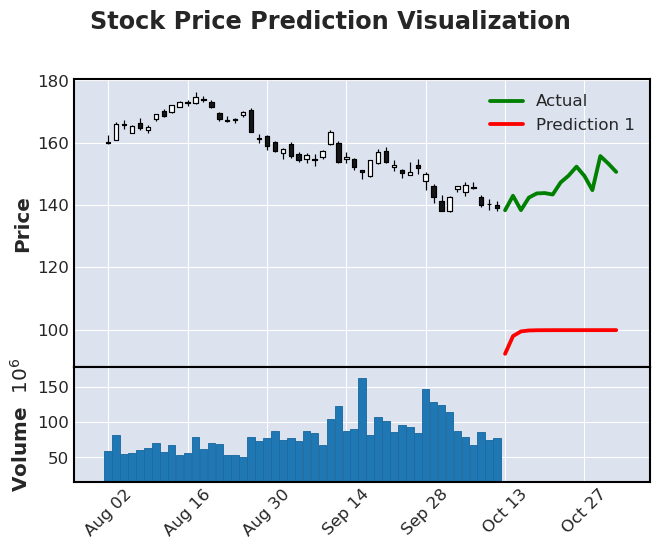

In [153]:
import matplotlib.pyplot as plt
for i in range(500,501):
    seq_element = total_cluster.test_seq_elements[i]
    # seq_element = total_cluster.train_seq_elements[i]

    close_price = X_test_close[i]
    close_price = close_price.reshape(-1,1)

    y_pred_cur = y_pred[i]
    y_true_cur = y_test_filtered[i]
    # y_pred_cur = y_train_pred[i]
    # y_true_cur = y_train_filtered[i]
    print(y_pred_cur)
    print(y_true_cur)

    paper_utils.visualize_future_movement_mpl_close(seq_element, [y_pred_cur], y_true_cur, trend_scaler, price_scaler)